J'ai juste fait petite analyse des features du dataset et analyse des games sous forme de serie temporelles.
Je pense que c'est plus parlant que juste une regression linéaire qui ne marche pas très bien avec un dataset petit et subjectif.

Dis moi si tu veux pousser dans une direction ou autre.

# Imports & configuration


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve


# Chargement & parsing manuel du CSV

In [26]:
# Remplace le chemin par le tien
path = "Petite analyse de la solo Q (très biaisée) - Stockage.csv"

# Lire brut
with open(path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Trouver la ligne contenant les headers
header_line = lines[12].strip()
header = next(csv.reader([header_line]))

# Parser toutes les lignes suivantes
data_rows = [next(csv.reader([L])) for L in lines[13:]]
maxlen = max(len(r) for r in data_rows)
norm_rows = [r + [""] * (maxlen - len(r)) for r in data_rows]

df_raw = pd.DataFrame(norm_rows)
df = df_raw.iloc[:, -len(header):].copy()
df.columns = [h.strip() for h in header]

df.head(10)


,,,Timing,Game,Ecart Niveau,Bienséance,Impact possible,Performance perso,Résultat,Commentaires
0,,,JOUR,1,8,10,8,9,Win,
1,,,JOUR,2,6,8,7,7,Win,
2,,,JOUR,3,7,4,5,5,Win,
3,,,JOUR,4,8,10,3,4,Win,
4,,,NUIT,5,1,7,2,7,Lose,
5,,,NUIT,6,3,3,0,0,Win,
6,,,NUIT,7,2,5,0,5,Lose,
7,,,NUIT,8,5,4,5,7,Win,
8,,,NUIT,9,1,2,0,6,Lose,
9,,,NUIT,10,1,2,0,8,Lose,


# Nettoyage & renommage des colonnes

In [34]:
df = df.rename(columns={
    "Timing": "timing",
    "Game": "game",
    "Ecart Niveau": "ecart_niveau",
    "Bienséance": "bienseance",
    "Impact possible": "impact_possible",
    "Performance perso": "perf_perso",
    "Résultat": "resultat",
    "Commentaires": "commentaires"
})

# Conversion types numériques
for col in ["game", "ecart_niveau", "bienseance", "impact_possible", "perf_perso"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Nettoyage des labels
df["resultat"] = df["resultat"].astype(str).str.strip().str.lower()
df["y_win"] = df["resultat"].map(lambda x: 1 if x.startswith("w") else (0 if x.startswith("l") else np.nan))
df["y_timing"] = df["timing"].map(lambda x: 1 if x.startswith("J") else (0 if x.startswith("N") else np.nan))


df["timing"] = df["timing"].astype(str).str.strip().str.upper().replace({"": np.nan})

df_clean = df.dropna(subset=["y_win"]).reset_index(drop=True)
df_clean.head(10)


,,,timing,game,ecart_niveau,bienseance,impact_possible,perf_perso,resultat,commentaires,y_win,y_timing
0,,,JOUR,1,8,10,8,9,win,,1,1
1,,,JOUR,2,6,8,7,7,win,,1,1
2,,,JOUR,3,7,4,5,5,win,,1,1
3,,,JOUR,4,8,10,3,4,win,,1,1
4,,,NUIT,5,1,7,2,7,lose,,0,0
5,,,NUIT,6,3,3,0,0,win,,1,0
6,,,NUIT,7,2,5,0,5,lose,,0,0
7,,,NUIT,8,5,4,5,7,win,,1,0
8,,,NUIT,9,1,2,0,6,lose,,0,0
9,,,NUIT,10,1,2,0,8,lose,,0,0


# Analyse exploratoire rapide

In [36]:
print("Total lignes :", len(df))
print("Lignes avec label :", df_clean["y_win"].notna().sum())

# Statistiques descriptives
desc = df_clean[["y_timing", "ecart_niveau", "bienseance", "impact_possible", "perf_perso", "y_win"]].describe().T
display(desc)

# Comptage par timing
print(df_clean["timing"].value_counts(dropna=False))


Total lignes : 27
Lignes avec label : 27


,count,mean,std,min,25%,50%,75%,max
y_timing,27.0,0.444444,0.506370,0.0,0.0,0.0,1.0,1.0
ecart_niveau,27.0,4.185185,3.211003,0.0,1.0,4.0,7.0,9.0
bienseance,27.0,5.370370,3.387172,0.0,2.0,5.0,8.5,10.0
impact_possible,27.0,2.851852,2.996199,0.0,0.0,2.0,5.0,9.0
perf_perso,27.0,6.407407,2.453557,0.0,5.0,7.0,8.0,10.0
y_win,27.0,0.592593,0.500712,0.0,0.0,1.0,1.0,1.0


timing
NUIT    15
JOUR    12
Name: count, dtype: int64


# Analyse des corrélations

=== Matrice complète de corrélation (features + victoire) ===


,y_timing,ecart_niveau,bienseance,impact_possible,perf_perso,y_win
y_timing,1.000000,0.207636,0.169429,0.070418,-0.089432,-0.016855
ecart_niveau,0.207636,1.000000,0.658275,0.602623,-0.097819,0.838157
bienseance,0.169429,0.658275,1.000000,0.555139,0.286593,0.477914
impact_possible,0.070418,0.602623,0.555139,1.000000,0.453238,0.676059
perf_perso,-0.089432,-0.097819,0.286593,0.453238,1.000000,-0.047540
y_win,-0.016855,0.838157,0.477914,0.676059,-0.047540,1.000000


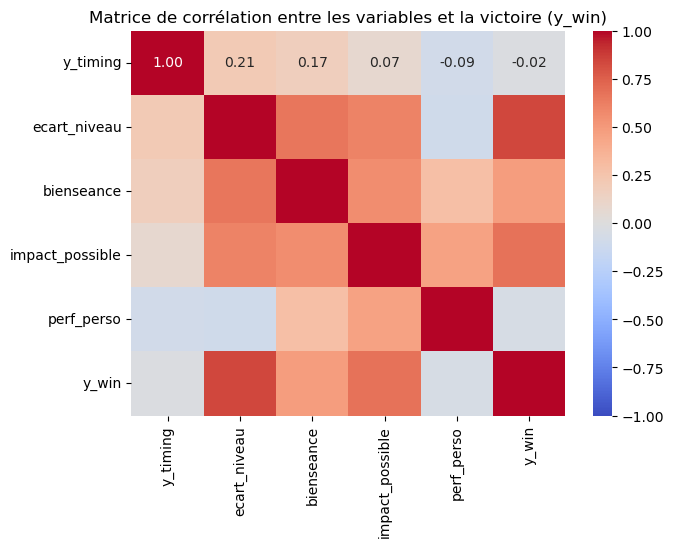


=== Corrélation individuelle avec la victoire (y_win) ===


perf_perso        -0.047540
y_timing          -0.016855
bienseance         0.477914
impact_possible    0.676059
ecart_niveau       0.838157
Name: y_win, dtype: float64

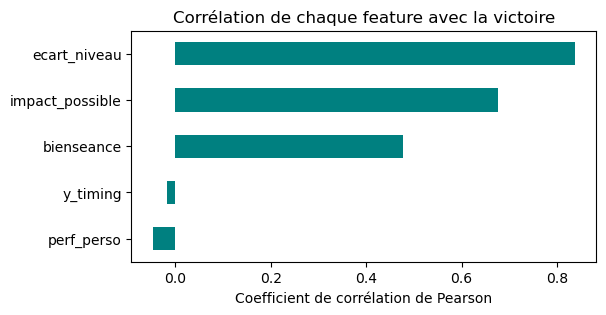

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = df_clean[["y_timing", "ecart_niveau", "bienseance", "impact_possible", "perf_perso", "y_win"]].copy()
corr_matrix = corr_df.corr()

print("=== Matrice complète de corrélation (features + victoire) ===")
display(corr_matrix)

plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Matrice de corrélation entre les variables et la victoire (y_win)")
plt.show()

# Corrélation avec la victoire uniquement
corr_with_win = corr_matrix["y_win"].drop("y_win").sort_values(ascending=True)

print("\n=== Corrélation individuelle avec la victoire (y_win) ===")
display(corr_with_win)

plt.figure(figsize=(6, 3))
corr_with_win.plot(kind="barh", color="teal")
plt.title("Corrélation de chaque feature avec la victoire")
plt.xlabel("Coefficient de corrélation de Pearson")
plt.show()


# Détection des streaks (séries de wins/loses consécutives)

In [38]:
df["streak_id"] = (df["y_win"].diff().fillna(0) != 0).cumsum()
streaks = df.groupby("streak_id")["y_win"].agg(["count", "mean"]).reset_index()
streaks["type"] = streaks["mean"].apply(lambda x: "Win Streak" if x == 1 else "Lose Streak")

df["streak_len"] = df.groupby("streak_id")["y_win"].transform("size")
df["streak_pos"] = df.groupby("streak_id").cumcount() + 1

display(streaks)


,streak_id,count,mean,type
0,0,4,1.0,Win Streak
1,1,1,0.0,Lose Streak
2,2,1,1.0,Win Streak
3,3,1,0.0,Lose Streak
4,4,1,1.0,Win Streak
5,5,2,0.0,Lose Streak
6,6,2,1.0,Win Streak
7,7,1,0.0,Lose Streak
8,8,2,1.0,Win Streak
9,9,3,0.0,Lose Streak


# Visualisation de la séquence de games

In [39]:
df['y_win'].value_counts

<bound method IndexOpsMixin.value_counts of 0     1
1     1
2     1
3     1
4     0
5     1
6     0
7     1
8     0
9     0
10    1
11    1
12    0
13    1
14    1
15    0
16    0
17    0
18    1
19    0
20    1
21    0
22    1
23    1
24    1
25    1
26    0
Name: y_win, dtype: int64>

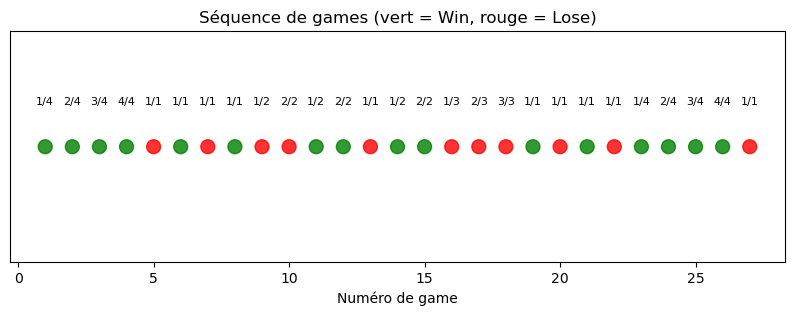

In [40]:
plt.figure(figsize=(10, 3))
colors = df["y_win"].map({1: "green", 0: "red"})
plt.scatter(df["game"], [1]*len(df), c=colors, s=100, alpha=0.8)
for i, row in df.iterrows():
    plt.text(row["game"], 1.02, f'{int(row["streak_pos"])}/{int(row["streak_len"])}', ha="center", fontsize=8)
plt.yticks([])
plt.title("Séquence de games (vert = Win, rouge = Lose)")
plt.xlabel("Numéro de game")
plt.show()


# Analyse des transitions (momentum entre parties)

Probabilités de transition entre games :


,Lose suivante,Win suivante
Après Lose,0.3,0.7
Après Win,0.5,0.5


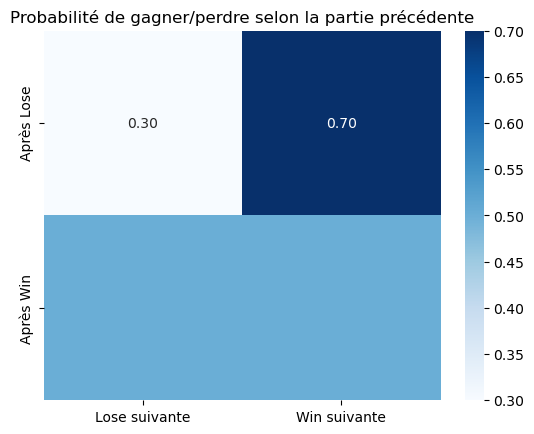

In [41]:
df["previous_result"] = df["y_win"].shift(1)
transitions = pd.crosstab(df["previous_result"], df["y_win"], normalize="index")

transitions.index = ["Après Lose", "Après Win"]
transitions.columns = ["Lose suivante", "Win suivante"]

print("Probabilités de transition entre games :")
display(transitions)

sns.heatmap(transitions, annot=True, cmap="Blues", fmt=".2f")
plt.title("Probabilité de gagner/perdre selon la partie précédente")
plt.show()


# Analyse du momentum selon la bienséance et la performance personnelle précédente

C:\Users\Rafael\AppData\Local\Temp\ipykernel_17836\1025516500.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat_bien = df.groupby(["bienseance_prev_cat", "bienseance_cat"])["y_win"].mean().unstack()


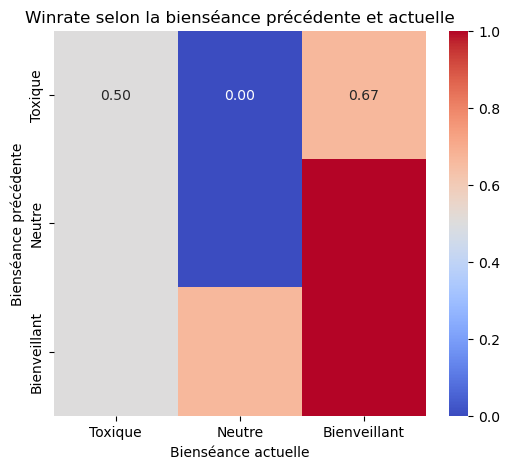

bienseance_cat,Toxique,Neutre,Bienveillant
bienseance_prev_cat,,,
Toxique,0.5,0.000000,0.666667
Neutre,0.5,0.000000,1.000000
Bienveillant,0.5,0.666667,1.000000


C:\Users\Rafael\AppData\Local\Temp\ipykernel_17836\1025516500.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat_perf = df.groupby(["perf_prev_cat", "perf_cat"])["y_win"].mean().unstack()
C:\Users\Rafael\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


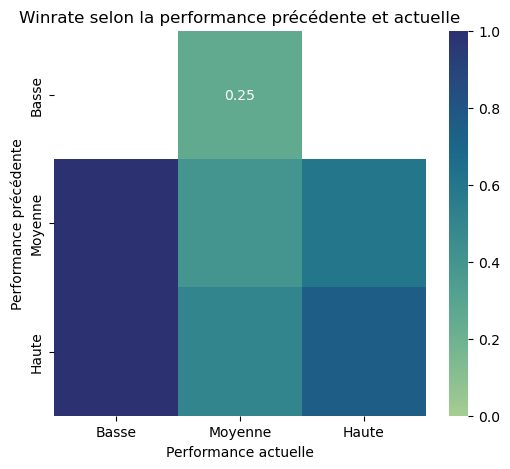

perf_cat,Basse,Moyenne,Haute
perf_prev_cat,,,
Basse,NaN,0.25,NaN
Moyenne,1.0,0.40,0.60
Haute,1.0,0.50,0.75


In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# === Préparation des variables précédentes ===
df["bienseance_prev"] = df["bienseance"].shift(1)
df["perf_prev"] = df["perf_perso"].shift(1)

# Catégorisation en 3 niveaux : basse / moyenne / haute
df["bienseance_cat"] = pd.cut(df["bienseance"], bins=[-1, 4, 7, 10],
                              labels=["Toxique", "Neutre", "Bienveillant"])
df["bienseance_prev_cat"] = pd.cut(df["bienseance_prev"], bins=[-1, 4, 7, 10],
                                   labels=["Toxique", "Neutre", "Bienveillant"])

df["perf_cat"] = pd.cut(df["perf_perso"], bins=[-1, 4, 7, 10],
                        labels=["Basse", "Moyenne", "Haute"])
df["perf_prev_cat"] = pd.cut(df["perf_prev"], bins=[-1, 4, 7, 10],
                             labels=["Basse", "Moyenne", "Haute"])

# === 1️⃣ Matrice Bienséance (t-1 vs t) ===
mat_bien = df.groupby(["bienseance_prev_cat", "bienseance_cat"])["y_win"].mean().unstack()

plt.figure(figsize=(6,5))
sns.heatmap(mat_bien, annot=True, cmap="coolwarm", fmt=".2f", vmin=0, vmax=1)
plt.title("Winrate selon la bienséance précédente et actuelle")
plt.xlabel("Bienséance actuelle")
plt.ylabel("Bienséance précédente")
plt.show()

display(mat_bien)

# === 2️⃣ Matrice Performance (t-1 vs t) ===
mat_perf = df.groupby(["perf_prev_cat", "perf_cat"])["y_win"].mean().unstack()

plt.figure(figsize=(6,5))
sns.heatmap(mat_perf, annot=True, cmap="crest", fmt=".2f", vmin=0, vmax=1)
plt.title("Winrate selon la performance précédente et actuelle")
plt.xlabel("Performance actuelle")
plt.ylabel("Performance précédente")
plt.show()

display(mat_perf)


# Analyse du momentum selon la bienséance et la performance personnelle des 3 games precedentes

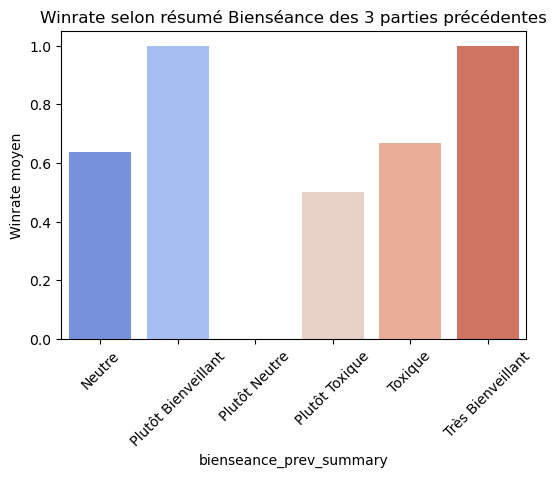

bienseance_prev_summary
Neutre                 0.636364
Plutôt Bienveillant    1.000000
Plutôt Neutre          0.000000
Plutôt Toxique         0.500000
Toxique                0.666667
Très Bienveillant      1.000000
Name: y_win, dtype: float64

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Décalage des 3 parties précédentes ===
for i in range(1, 4):
    df[f"bienseance_prev{i}"] = df["bienseance"].shift(i)
    df[f"perf_prev{i}"] = df["perf_perso"].shift(i)

# === Catégorisation initiale ===
labels_bien = ["Toxique", "Neutre", "Bienveillant"]
labels_perf = ["Basse", "Moyenne", "Haute"]

for i in range(1,4):
    df[f"bienseance_prev{i}_cat"] = pd.cut(df[f"bienseance_prev{i}"], bins=[-1,4,7,10], labels=labels_bien)
    df[f"perf_prev{i}_cat"] = pd.cut(df[f"perf_prev{i}"], bins=[-1,4,7,10], labels=labels_perf)

# === Fonction pour résumer les 3 parties précédentes ===
def summarise_prev(row, cols):
    counts = pd.Series([row[c] for c in cols]).value_counts()
    # Bienséance
    if "Toxique" in counts:
        if counts["Toxique"] == 3: return "Toxique"
        elif counts["Toxique"] == 2: return "Plutôt Toxique"
        elif counts["Toxique"] == 1: return "Neutre"
    if "Neutre" in counts:
        if counts["Neutre"] == 3: return "Neutre"
        elif counts["Neutre"] == 2: return "Plutôt Neutre"
        elif counts["Neutre"] == 1: return "Neutre"
    if "Bienveillant" in counts:
        if counts["Bienveillant"] == 3: return "Très Bienveillant"
        elif counts["Bienveillant"] == 2: return "Plutôt Bienveillant"
        elif counts["Bienveillant"] == 1: return "Neutre"
    return "Neutre"

# === Résumé des 3 parties précédentes ===
df["bienseance_prev_summary"] = df.apply(summarise_prev, axis=1,
                                        cols=[f"bienseance_prev{i}_cat" for i in range(1,4)])
df["perf_prev_summary"] = df.apply(summarise_prev, axis=1,
                                   cols=[f"perf_prev{i}_cat" for i in range(1,4)])

# === Winrate moyen par résumé Bienséance ===
winrate_bien = df.groupby("bienseance_prev_summary")["y_win"].mean().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=winrate_bien.index, y=winrate_bien.values, palette="coolwarm")
plt.ylabel("Winrate moyen")
plt.title("Winrate selon résumé Bienséance des 3 parties précédentes")
plt.xticks(rotation=45)
plt.show()

display(winrate_bien)

# Analyse par période de la journée (Jour/Nuit)

timing
NUIT    0.600000
JOUR    0.583333
Name: y_win, dtype: float64

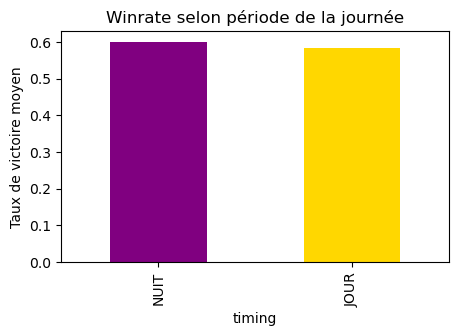

,ecart_niveau,bienseance,impact_possible,perf_perso
timing,,,,
JOUR,4.916667,6.000000,3.083333,6.166667
NUIT,3.600000,4.866667,2.666667,6.600000


In [42]:
win_rate_timing = df.groupby("timing")["y_win"].mean().sort_values(ascending=False)
display(win_rate_timing)

plt.figure(figsize=(5, 3))
win_rate_timing.plot(kind="bar", color=["gold" if t == "JOUR" else "purple" for t in win_rate_timing.index])
plt.ylabel("Taux de victoire moyen")
plt.title("Winrate selon période de la journée")
plt.show()

moyennes_timing = df.groupby("timing")[["ecart_niveau", "bienseance", "impact_possible", "perf_perso"]].mean()
display(moyennes_timing)


# Analyse du momentum et fatigue potentielle

Évolution moyenne après une lose ou une win :


,delta_perf,delta_impact
Après Lose,-0.400,1.800
Après Win,0.125,-1.625


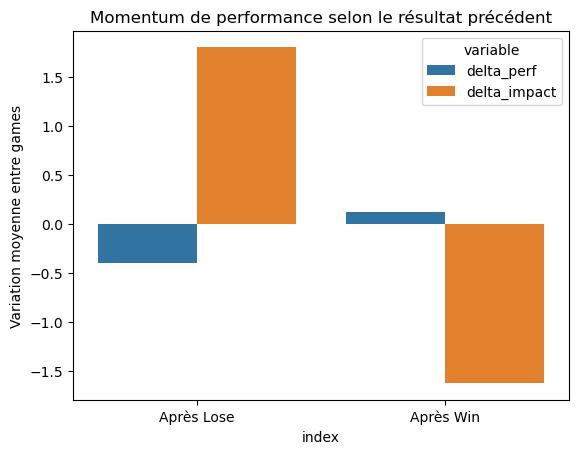

In [43]:
# Variation des peformances entre games successives
df["delta_perf"] = df["perf_perso"].diff()
df["delta_impact"] = df["impact_possible"].diff()

momentum = df.groupby("previous_result")[["delta_perf", "delta_impact"]].mean()
momentum.index = ["Après Lose", "Après Win"]

print("Évolution moyenne après une lose ou une win :")
display(momentum)

sns.barplot(data=momentum.reset_index().melt(id_vars="index"), x="index", y="value", hue="variable")
plt.ylabel("Variation moyenne entre games")
plt.title("Momentum de performance selon le résultat précédent")
plt.show()
